# Parameter Estimation: Maximum likelihood

In the previous section, we've seen how to use Markov Chain Monte Carlo methods to estimate the posterior probability distribution of parameters.
These methods have generally replaced techniques which use algorithms to infer the maximum likelihood estimates (MLE) of parameter values, with confidence levels provided after making assumptions about the local likelihood landscape.
PyGOM has the capability to estimate parameters in this way and although perhaps outdated, including these methods could still be practical if trying to reproduce work from older publications, for example.

## Example: SEIR model (with I and R known)

We now solve the same problem as in the previous section, this time via minimisation of the cost function.
As a reminder: We have data from an SEIR system where the time series of $I$ and $R$ are known and we wish to estimate parameters $\beta$, $\alpha$ and $\gamma$ with true values 0.35, 0.5 and 0.25 respectively.
We assume that the total population, $N=10,000$ and the initial number infecteds, $i_0=5$, are both known.

We start by loading the data again:

In [1]:
# Import data
import numpy as np

out = np.loadtxt('seir_epi_data.txt')
t=out[:,0]
sol_i_r=out[:,1:3]

The syntax for setting up the solver is similar to the approach via ABC.
We first form our candidate SEIR model.
Again, we must specify some values for $\beta$, $\alpha$ and $\gamma$, even if we don't know them.
Here we put zeros, but anything else would be acceptable.

In [2]:
from pygom import common_models

n_pop=1e4
paramEval=[('beta', 0), ('alpha', 0), ('gamma', 0), ('N', n_pop)]
ode_SEIR = common_models.SEIR_N_stochastic(param=paramEval)

We provide an initial guess in `theta` and pass all other required information, including initial conditions `x0`, to build an object of class {class}`PoissonLoss`

In [3]:
theta = [0.4, 0.3, 0.3]  # initial guess

i0=5
x0=[n_pop-i0, 0, i0, 0]  # initial conditions

from pygom import PoissonLoss

objSEIR = PoissonLoss(theta, ode_SEIR,
                      t0=t[0], x0=x0,
                      t=t[1:], y=sol_i_r[1:,:],
                      target_param=['beta', 'alpha', 'gamma'],
                      state_name= ['I', 'R'])

```{note}
It is a good idea to check that value of $R_0$ corresponding to the initial guess is greater than 1.
For instance, here $\frac{\beta}{\gamma}=\frac{0.4}{0.3}=1.33$.
This is important because if $R_0<1$ then the resulting model output will be an exponential decay - essentially, a failed epidemic which will differ substantially from the data.
If the optimization algorithm proceeds by attempting new sets of parameters in the neighbourhood of the initial ones, these are also likely to result in similarly bad model fits and the algorithm may not find a way out.
```

## Gradient calculations

How the parameter optimizer will navigate parameter space will depend on the gradient of the cost function with respect to the parameters.
PyGOM can calculate the gradient in two different ways.
First, let's compare the outputs of the two methods when evaluated at the initial condition, `theta`:

In [ ]:
print(objSEIR.sensitivity())
print(objSEIR.adjoint())

Also, let's compare the times each method takes:

In [ ]:
%timeit objSEIR.sensitivity()

In [ ]:
%timeit objSEIR.adjoint()

```{note}
Note how we ran the two gradient functions once before timing it, that is because we only find the properties (Jacobian, gradient) of the ODEs during runtime.

The amount of time taken for both methods is dependent on the number of observations as well as the number of states.
The effect on the adjoint method as the number of observations differs can be quite evident.
This is because the adjoint method is under a discretization which loops in Python where as the forward sensitivity equations are solved via an integration.
As the number of observation gets larger, the affect of the Python loop becomes more obvious.

The difference in gradient is larger when there are less observations.
This is because the adjoint method use interpolations on the output of the ode between each consecutive time points.
Given solutions over the same length of time, fewer discretizations leads to a less accurate interpolation.
Note that the interpolation is currently performed using a univariate spline, due to the limitation of Python packages.
Ideally, one would prefer to use an (adaptive) Hermite or Chebyshev interpolation.

#TODO refs
```

## Optimised result

We now employ optimisation procedures which should progress from the initial guess (if the initial guess is sensible enough) to the parameter set which minimises our cost function.
It is particularly important to set the boundaries for the parameters here, since we know that they are required to be positive.

In [4]:
boxBounds = [(0.0,2.0), (0.0,2.0), (0.0,2.0)]

Now we use the *SLSQP* optimization routine of `scipy.optimize` with gradient obtained by forward sensitivity.

We could, of course, use other methods available in `scipy.optimize.minimize`, such as *L-BFGS-B* and *TNC*.
We can also use methods that accepts the exact Hessian such as *trust-ncg* but that should not be necessary most of the time.

In [5]:
from scipy.optimize import minimize

res = minimize(fun=objSEIR.cost,
               jac=objSEIR.sensitivity,
               x0=theta, 
               bounds=boxBounds,
               method='SLSQP')

print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1651.128217170814
       x: [ 3.537e-01  5.384e-01  2.559e-01]
     nit: 17
     jac: [-4.531e+00 -3.594e-01  4.575e+00]
    nfev: 29
    njev: 17


We see that parameter values are in agreement with the underlying model and there is visual agreement with data when plotted below

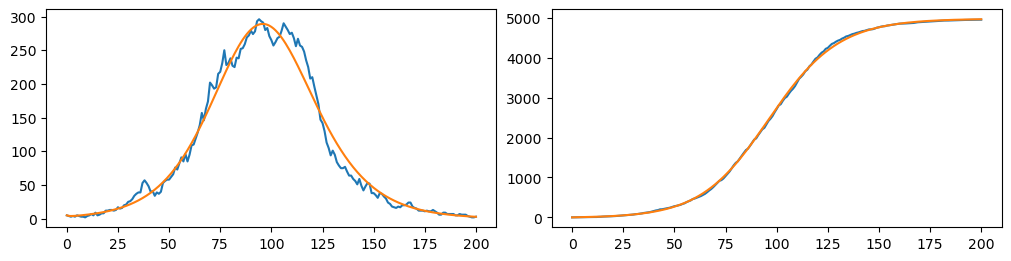

In [6]:
pars=res.x

ode_est = common_models.SEIR_N_stochastic([('beta', pars[0]), ('alpha', pars[1]), ('gamma', pars[2]), ('N', n_pop)])
ode_est.initial_values = (x0, t[0])
solution = ode_est.integrate(t[1::])

import matplotlib.pyplot as plt
f, axarr = plt.subplots(1,2, layout='constrained', figsize=(10, 2.5))

axarr[0].plot(t, sol_i_r[:,0], color='C0')
axarr[0].plot(t, solution[:,2], color='C1')
axarr[1].plot(t, sol_i_r[:,1], color='C0')
axarr[1].plot(t, solution[:,3], color='C1');

## Confidence intervals of estimated parameters

Point estimates of parameters found via MLE provide the *best* fit, but are incomplete without some measure of their uncertainty.
With the ABC method of the previous section, credible intervals fall out as part of the fitting process, since the output is parameter probability distributions.
For parameter estimates found via optimisation, we need to make some assumptions about the shape of the likelihood function in the neighbourhood of the MLE to obtain confidence levels.

```{warning}
PyGOM has built in functions using different methods to solve this problem.
These are, however, under development.
The location and names of the relevant code can be found below and they should be carefully inspected before being employed.
```

In [2]:
#from pygom import confidence_interval as ci

## Different methods for CIs:
# ci.asymptotic
# ci.profile
# ci.bootstrap
# ci.geometric